In [958]:
import torch
import glob
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [959]:
from sklearn.neighbors import KNeighborsClassifier

In [965]:
num_epochs = 2
num_classes = 10
batch_size = 25
learning_rate = 0.001
print_times_for_every_epoch = 100
MODEL_STORE_PATH = './Model'

In [961]:
def showImage(image):
    plt.figure()
    image = image.numpy()
    image = image.transpose(1, 2, 0)
    image = np.squeeze(image, axis=2)
    plt.imshow(image)
    plt.show()

In [984]:
def cleanData(image, labelclss):
    
    diffs = torch.zeros(0, 1, 28, 28)
    for i in range(image.shape[0]):
        im = image[i]
        diff = im - image
        diff = torch.abs(diff)
        diff = diff.mean(0)
        diff = diff.unsqueeze(0)
        #print(diff.shape)
        diffs = torch.cat((diffs, diff), 0)
        print(f'Image No. Difference {i} is processed')
        
    stnDev = diffs.std(0)
    newDataSet = torch.zeros(0, 1, 28, 28)

    ##print(stnDev.shape)
    #print(Xtr[0].shape)

    stnDev = stnDev.mean(0).mean(0).mean(0)

    for i in range(image.shape[0]):
        if ((image[i].mean(0).mean(0).mean(0)<stnDev.mean(0).mean(0).mean(0)*(1.5)) 
            and (image[i].mean(0).mean(0).mean(0)>stnDev.mean(0).mean(0).mean(0)*(-1.5))):
            newDataSet = torch.cat((newDataSet, image[i].unsqueeze(0)), 0)
            print(f'Image No. {i} is processed')
    
    newlabels = []
    for i in range(newDataSet.shape[0]):
        newlabels.append(labelclss[i])
    
    return newDataSet, newlabels
    

In [962]:
def reClassify(imag, lblclss):
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    #for i in range(imag.shape[0]):
    nsamples, nchannels, nx, ny = imag.numpy().shape
    d2_imag = imag.numpy().reshape((nsamples*nchannels,nx*ny))
    
    knn.fit(d2_imag, lblclss)
    
    #y_pred = []
    #for i in range(imag.shape[0]):
        #y_pred.append = knn.predict(imag[i].numpy())
    
    
    y_pred = knn.predict(d2_imag)
    y_pred.tolist()
    l2 = [int(v) for v in y_pred]
    
    return imag, l2

In [963]:
def readData(train=True, mix=False, cData=False):
    
    if (train):
        typ="training"
    else:
        typ="testing"
        
    if (mix):
        fold="mnist_png_mixtrain50"
    else:
        fold="mnist_png"
        
    
    images = torch.zeros(0, 1, 28, 28)
    label = []
    
    
    for i in range(10):
        count = 0
        #image and labelclss hold images and labels of one class
        image = torch.zeros(0, 1, 28, 28)
        labelclss = []
        for file in glob.glob(f'./{fold}/{typ}/{i}/*'):
            img = Image.open(file)
            img = TF.to_tensor(img)  
            img.unsqueeze_(0)
            
            image = torch.cat((image, img), 0)
            labelclss.append(i)
            count = count + 1
                
            if (count>500):
                break
                
        if (cData and train):
            imag, lblclss = cleanData(image, labelclss)
            
            #imag, lblclss = reClassify(image, labelclss)
            #imag, lblclss = cleanData(imag, lblclss)            
            
            #images holds the whole dataset
            images = torch.cat((images, imag), 0) 
            label.extend(lblclss)
                
        if (not cData) or (not train):
            #images holds the whole dataset
            images = torch.cat((images, image), 0)
            label.extend(labelclss)
        #print(images.shape)
        #print(len(label))
    images, label = reClassify(images, label)
    

    ##print(label[5])
    #showImage(images[5])

        
    return images, label

In [964]:
Xtr, Ytr = readData()
Xts, Yts = readData(train=False)

In [966]:
Yts[23]
len(Ytr)

60000

In [967]:
Xtr.shape

torch.Size([60000, 1, 28, 28])

In [969]:
train_dataset = []
test_dataset = []
for i in range(Xtr.shape[0]):
   train_dataset.append([Xtr[i], Ytr[i]])
for i in range(Xts.shape[0]):
   test_dataset.append([Xts[i], Yts[i]])

In [970]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [971]:
NumberOfBatches = len(train_loader)
print (NumberOfBatches)

2400


In [972]:
printNow = NumberOfBatches/print_times_for_every_epoch
print(printNow)

24.0


In [973]:
img, lbl = next(iter(train_loader))

In [974]:
img.shape

torch.Size([25, 1, 28, 28])

In [975]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [976]:
model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [977]:
imgs, lbls = next(iter(train_loader))

In [978]:
lbls.shape
lbls[1]

tensor(3)

In [979]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
Yacc = []
Yloss = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list.append(correct / total)
        #print(i)

        if (i + 1) % int(printNow) == 0:
            Yacc.append((correct / total) * 100)
            Yloss.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [24/2400], Loss: 0.7815, Accuracy: 68.00%
Epoch [1/2], Step [48/2400], Loss: 0.4348, Accuracy: 92.00%
Epoch [1/2], Step [72/2400], Loss: 0.1790, Accuracy: 92.00%
Epoch [1/2], Step [96/2400], Loss: 0.1680, Accuracy: 92.00%
Epoch [1/2], Step [120/2400], Loss: 0.3722, Accuracy: 88.00%
Epoch [1/2], Step [144/2400], Loss: 0.3063, Accuracy: 92.00%
Epoch [1/2], Step [168/2400], Loss: 0.2170, Accuracy: 92.00%
Epoch [1/2], Step [192/2400], Loss: 0.3444, Accuracy: 84.00%
Epoch [1/2], Step [216/2400], Loss: 0.0433, Accuracy: 100.00%
Epoch [1/2], Step [240/2400], Loss: 0.0274, Accuracy: 100.00%
Epoch [1/2], Step [264/2400], Loss: 0.0721, Accuracy: 100.00%
Epoch [1/2], Step [288/2400], Loss: 0.1087, Accuracy: 92.00%
Epoch [1/2], Step [312/2400], Loss: 0.1051, Accuracy: 96.00%
Epoch [1/2], Step [336/2400], Loss: 0.0572, Accuracy: 100.00%
Epoch [1/2], Step [360/2400], Loss: 0.4082, Accuracy: 88.00%
Epoch [1/2], Step [384/2400], Loss: 0.0491, Accuracy: 100.00%
Epoch [1/2], Step [408/

In [980]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

Test Accuracy of the model: 98.85000000000001 %


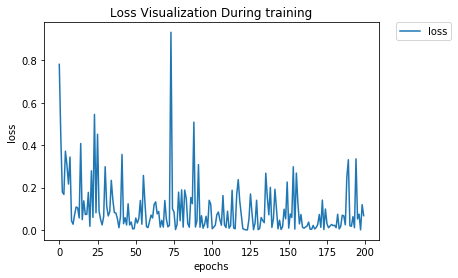

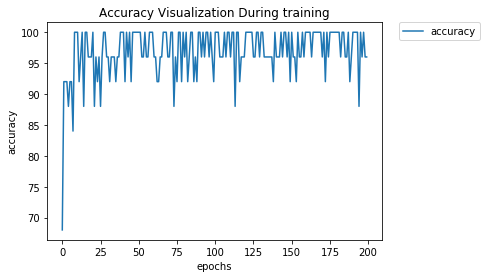

In [981]:

# plotting the points  
plt.plot(Yloss, label="loss") 

  
# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('loss') 
  
# giving a title to my graph 
plt.title('Loss Visualization During training') 
  
# function to show the plot 
plt.show() 

plt.plot(Yacc, label="accuracy") 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('accuracy') 
plt.title('Accuracy Visualization During training') 

plt.show()


Expected Label: 8 Correct Label: 8


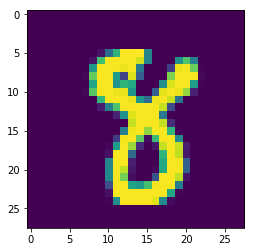

Expected Label: 0 Correct Label: 0


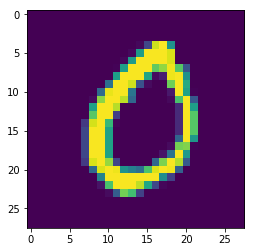

Expected Label: 5 Correct Label: 5


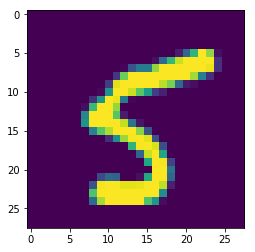

Expected Label: 5 Correct Label: 5


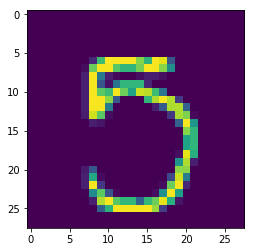

Expected Label: 5 Correct Label: 5


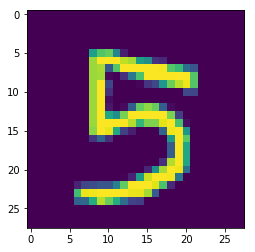

Expected Label: 3 Correct Label: 3


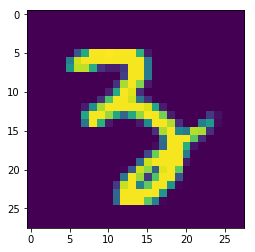

Expected Label: 4 Correct Label: 4


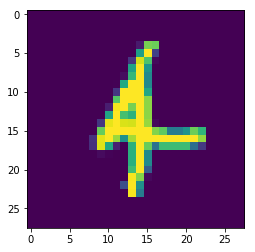

Expected Label: 0 Correct Label: 0


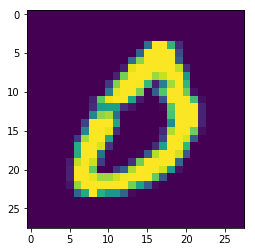

Expected Label: 5 Correct Label: 5


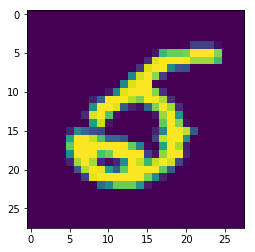

Expected Label: 7 Correct Label: 7


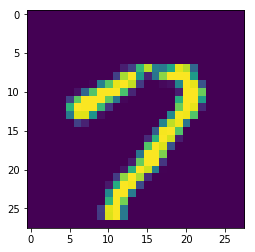

In [982]:
model.eval()
for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)


for i in range(10):
    print(f'Expected Label: {predicted[i]} Correct Label: {labels[i]}')
    showImage(images[i])

# Next Part of Homework

In [983]:
class ConvNetMix(nn.Module):
    def __init__(self):
        super(ConvNetMix, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [880]:
diffs = torch.zeros(0, 1, 28, 28)
for i in range(Xtr.shape[0]):
    im = Xtr[i]
    diff = im - Xtr
    diff = diff.mean(0)
    diff = torch.abs(diff)
    diff = diff.unsqueeze(0)
    #print(diff.shape)
    diffs = torch.cat((diffs, diff), 0)
        
stnDev = diffs.std(0)
newDataSet = torch.zeros(0, 1, 28, 28)

##print(stnDev.shape)
#print(Xtr[0].shape)

stnDev = stnDev.mean(0).mean(0).mean(0)

for i in range(Xtr.shape[0]):
    if ((Xtr[i].mean(0).mean(0).mean(0)<stnDev.mean(0).mean(0).mean(0)*(1)) 
        and (Xtr[i].mean(0).mean(0).mean(0)>stnDev.mean(0).mean(0).mean(0)*(-1))):
        newDataSet = torch.cat((newDataSet, Xtr[i].unsqueeze(0)), 0)
    
newlabels = []
for i in range(newDataSet.shape[0]):
    newlabels.append(Ytr[i])
    

print(len(newlabels))
print(newDataSet.shape)

1263
torch.Size([1263, 1, 28, 28])


In [881]:
#for i in range(Xtr.shape[0]):
im = Xtr[0]
#im = im.unsqueeze(0)
d = im - Xtr
print(d.shape)
print(im.shape)
print(Xtr.shape)



torch.Size([5010, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([5010, 1, 28, 28])


In [882]:
a = torch.Tensor([[[2,2],[3,4]],[[5,6],[7,8]]])
b = torch.Tensor([[1,2],[3,4]])

print(a)
print(b)
print(a.shape)
print(b.shape)
r = b - a
print(r.shape)
print(r)
r = r.mean(0)
print(r.shape)

tensor([[[2., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])
tensor([[1., 2.],
        [3., 4.]])
torch.Size([2, 2, 2])
torch.Size([2, 2])
torch.Size([2, 2, 2])
tensor([[[-1.,  0.],
         [ 0.,  0.]],

        [[-4., -4.],
         [-4., -4.]]])
torch.Size([2, 2])


In [985]:
Xtrm, Ytrm = readData(mix=True)
Xtsm, Ytsm = readData(train=False, mix=True)

#Xtrm, Ytrm = readData(mix=True, cleanData=True)
#Xtsm, Ytsm = readData(train=False, mix=True, cleanData=True)





In [986]:
print(len(Ytsm))
print(Xtsm.shape)
print(len(Ytrm))
print(Xtrm.shape)

10000
torch.Size([10000, 1, 28, 28])
60000
torch.Size([60000, 1, 28, 28])


In [987]:
trainM_dataset = []
testM_dataset = []

for i in range(Xtrm.shape[0]):
   trainM_dataset.append([Xtrm[i], Ytrm[i]])
for i in range(Xtsm.shape[0]):
   testM_dataset.append([Xtsm[i], Ytsm[i]])

trainM_loader = DataLoader(dataset=trainM_dataset, batch_size=batch_size, shuffle=True)
testM_loader = DataLoader(dataset=testM_dataset, batch_size=batch_size, shuffle=True)

In [988]:

print(Xtrm.shape[0])

60000


In [989]:
imgs, lbls = next(iter(trainM_loader))
print(imgs.shape)
mean = imgs.mean(2)
mean = mean.mean(2)
print(mean.shape)

torch.Size([25, 1, 28, 28])
torch.Size([25, 1])


In [990]:
model2 = ConvNetMix ()

# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [991]:
# Train the model
total_step2 = len(trainM_loader)
loss_list2 = []
acc_list2 = []
Yacc2 = []
Yloss2 = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(trainM_loader):
        # Run the forward pass
        outputs = model2(imgs)
        #print(outputs.shape)
        loss = criterion2(outputs, lbls)
        loss_list2.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list2.append(correct / total)

        if (i + 1) % int(printNow) == 0:
            Yacc2.append((correct / total) * 100)
            Yloss2.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [24/2400], Loss: 2.1870, Accuracy: 24.00%
Epoch [1/2], Step [48/2400], Loss: 2.1240, Accuracy: 36.00%
Epoch [1/2], Step [72/2400], Loss: 2.2171, Accuracy: 32.00%
Epoch [1/2], Step [96/2400], Loss: 2.0159, Accuracy: 36.00%
Epoch [1/2], Step [120/2400], Loss: 1.9491, Accuracy: 52.00%
Epoch [1/2], Step [144/2400], Loss: 1.8905, Accuracy: 48.00%
Epoch [1/2], Step [168/2400], Loss: 2.1202, Accuracy: 40.00%
Epoch [1/2], Step [192/2400], Loss: 1.9605, Accuracy: 40.00%
Epoch [1/2], Step [216/2400], Loss: 1.9625, Accuracy: 40.00%
Epoch [1/2], Step [240/2400], Loss: 2.0507, Accuracy: 36.00%
Epoch [1/2], Step [264/2400], Loss: 2.2154, Accuracy: 36.00%
Epoch [1/2], Step [288/2400], Loss: 1.9620, Accuracy: 48.00%
Epoch [1/2], Step [312/2400], Loss: 1.9644, Accuracy: 44.00%
Epoch [1/2], Step [336/2400], Loss: 1.9135, Accuracy: 44.00%
Epoch [1/2], Step [360/2400], Loss: 1.8588, Accuracy: 52.00%
Epoch [1/2], Step [384/2400], Loss: 1.8467, Accuracy: 40.00%
Epoch [1/2], Step [408/2400]

In [992]:
# Test the model
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testM_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))


Test Accuracy of the model: 95.74000000000001 %


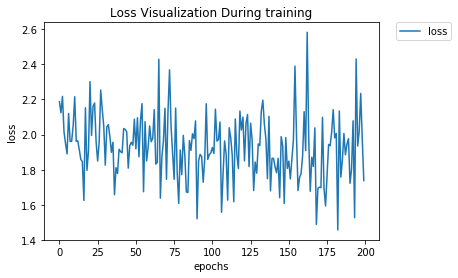

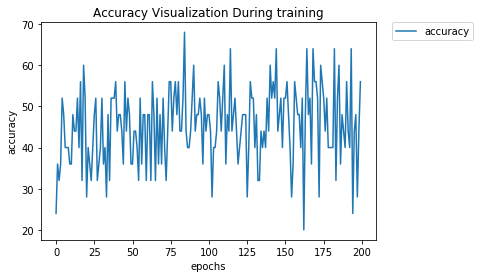

In [993]:

plt.plot(Yloss2, label="loss") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs')
plt.ylabel('loss') 
plt.title('Loss Visualization During training') 
plt.show() 


plt.plot(Yacc2, label="accuracy") 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) 
plt.xlabel('epochs') 
plt.ylabel('accuracy') 
plt.title('Accuracy Visualization During training') 

plt.show()

Expected Label: 9 Correct Label: 9


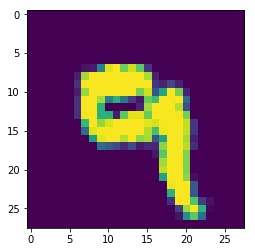

Expected Label: 9 Correct Label: 9


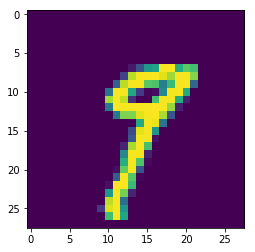

Expected Label: 7 Correct Label: 7


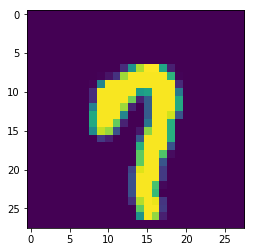

Expected Label: 2 Correct Label: 2


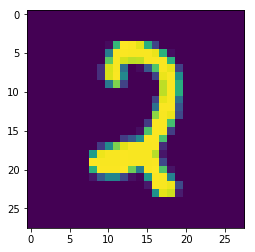

Expected Label: 1 Correct Label: 1


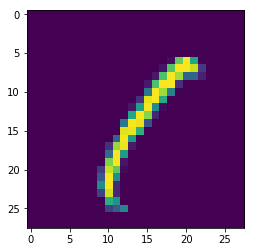

Expected Label: 2 Correct Label: 2


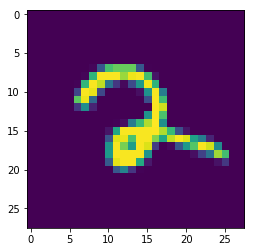

Expected Label: 3 Correct Label: 3


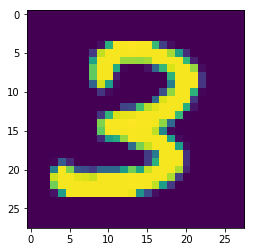

Expected Label: 7 Correct Label: 7


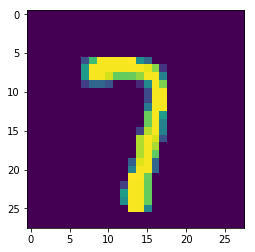

Expected Label: 7 Correct Label: 7


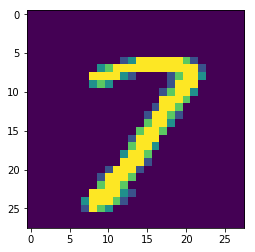

Expected Label: 4 Correct Label: 4


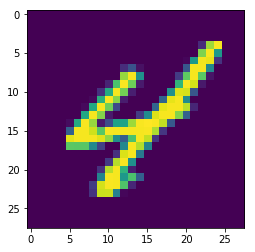

In [994]:
model2.eval()
for images, labels in testM_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)


for i in range(10):
    print(f'Expected Label: {predicted[i]} Correct Label: {labels[i]}')
    showImage(images[i])

In [995]:
#Xtrm, Ytrm = readData(mix=True)
#Xtsm, Ytsm = readData(train=False, mix=True)

Xtrm, Ytrm = readData(mix=True, cData=True)
Xtsm, Ytsm = readData(train=False, mix=True, cData=True)


In [996]:
print(len(Ytsm))
print(Xtsm.shape)
print(len(Ytrm))
print(Xtrm.shape)

10000
torch.Size([10000, 1, 28, 28])
32395
torch.Size([32395, 1, 28, 28])


0


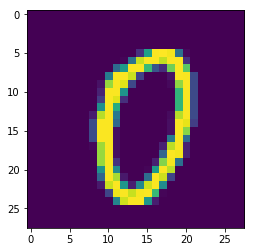

0


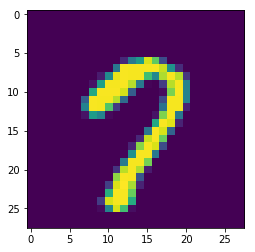

0


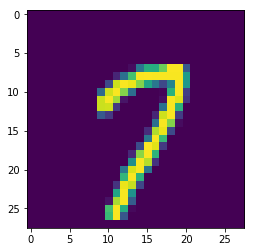

0


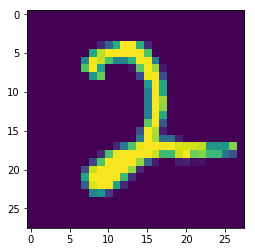

0


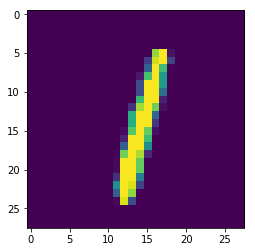

0


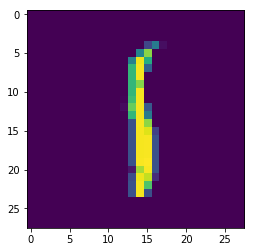

0


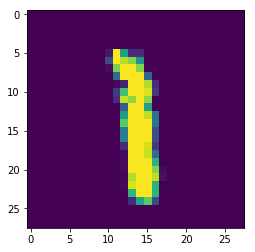

0


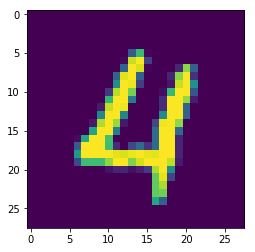

0


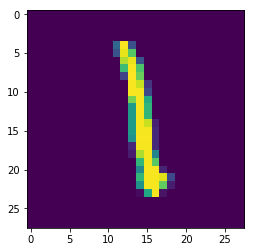

0


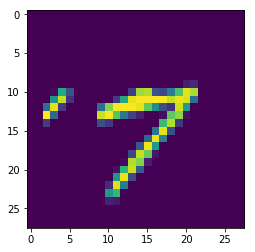

0


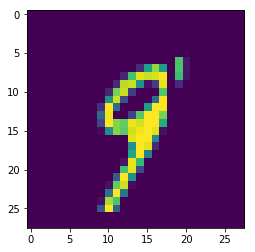

0


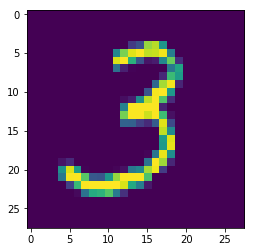

0


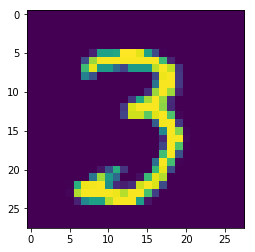

0


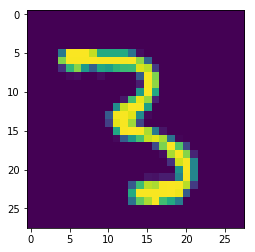

0


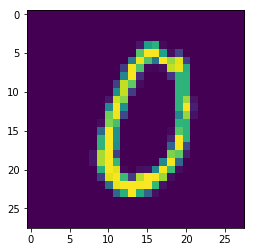

0


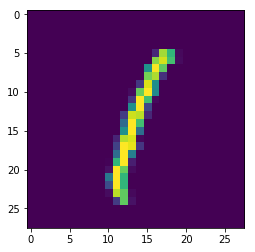

0


KeyboardInterrupt: 

In [997]:
for i in range(708):
    print(Ytrm[i])
    showImage(Xtrm[i])

In [998]:
trainM_dataset = []
testM_dataset = []

for i in range(Xtrm.shape[0]):
   trainM_dataset.append([Xtrm[i], Ytrm[i]])
for i in range(Xtsm.shape[0]):
   testM_dataset.append([Xtsm[i], Ytsm[i]])

trainM_loader = DataLoader(dataset=trainM_dataset, batch_size=batch_size, shuffle=True)
testM_loader = DataLoader(dataset=testM_dataset, batch_size=batch_size, shuffle=True)

In [999]:
model2 = ConvNetMix ()

# Loss and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [1000]:
# Train the model
total_step2 = len(trainM_loader)
loss_list2 = []
acc_list2 = []
Yacc2 = []
Yloss2 = []
for epoch in range(num_epochs):
    for i, (imgs, lbls) in enumerate(trainM_loader):
        # Run the forward pass
        outputs = model2(imgs)
        #print(outputs.shape)
        loss = criterion2(outputs, lbls)
        loss_list2.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        # Track the accuracy
        total = lbls.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == lbls).sum().item()
        acc_list2.append(correct / total)

        if (i + 1) % int(printNow) == 0:
            Yacc2.append((correct / total) * 100)
            Yloss2.append(loss.item())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/2], Step [24/2400], Loss: 2.4288, Accuracy: 8.00%
Epoch [1/2], Step [48/2400], Loss: 2.1254, Accuracy: 36.00%
Epoch [1/2], Step [72/2400], Loss: 2.1955, Accuracy: 32.00%
Epoch [1/2], Step [96/2400], Loss: 2.1280, Accuracy: 40.00%
Epoch [1/2], Step [120/2400], Loss: 1.9545, Accuracy: 32.00%
Epoch [1/2], Step [144/2400], Loss: 2.0497, Accuracy: 28.00%
Epoch [1/2], Step [168/2400], Loss: 2.0350, Accuracy: 44.00%
Epoch [1/2], Step [192/2400], Loss: 1.6707, Accuracy: 56.00%
Epoch [1/2], Step [216/2400], Loss: 2.2024, Accuracy: 32.00%
Epoch [1/2], Step [240/2400], Loss: 1.9164, Accuracy: 40.00%
Epoch [1/2], Step [264/2400], Loss: 1.9858, Accuracy: 40.00%
Epoch [1/2], Step [288/2400], Loss: 2.1684, Accuracy: 32.00%
Epoch [1/2], Step [312/2400], Loss: 2.2652, Accuracy: 24.00%
Epoch [1/2], Step [336/2400], Loss: 1.6984, Accuracy: 68.00%
Epoch [1/2], Step [360/2400], Loss: 1.8101, Accuracy: 52.00%
Epoch [1/2], Step [384/2400], Loss: 2.2814, Accuracy: 32.00%
Epoch [1/2], Step [408/2400],

In [1001]:
# Test the model
model2.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testM_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))


Test Accuracy of the model: 83.34 %
